In [1]:
!pip install -q -U google-generativeai
!pip install openai
!pip install anthropic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 4.0 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from google.colab import userdata
from google.colab import drive
from sklearn.metrics import mean_squared_error, f1_score

drive.mount('/content/drive')

# Load the JSON file
news_path = "/content/drive/MyDrive/0_2024_CarbonMarket_Sentiment/Data_news/all_news.json"

# Read the JSON file
try:
    with open(news_path, 'r', encoding='utf-8') as f:
        all_news = json.load(f)
except FileNotFoundError:
    raise Exception(f"File not found: {file_path}")
except json.JSONDecodeError:
    raise Exception("Error decoding JSON. Please check the file content.")

if isinstance(all_news, list):
    all_news = pd.DataFrame(all_news)

price_path = "/content/drive/MyDrive/0_2024_CarbonMarket_Sentiment/LCFS_task/LCFS_monthly.csv"
lcfs = pd.read_csv(price_path)

Mounted at /content/drive


In [3]:
all_news['date'] = pd.to_datetime(all_news['date'])
all_news['date'] = all_news['date'].dt.strftime('%Y-%m-%d')
all_news

,date,source,title,second_title,content
0,2010-02-02,The California Air Resources Board,ARB Chairman Mary Nichols issues comment on la...,None,In response to a lawsuit brought by the Natio...
1,2010-02-03,The California Air Resources Board,ARB applauds EPA’s renewable fuels announcement,None,In response to the announcement made today by ...
2,2011-12-16,The California Air Resources Board,Air Resources Board moves forward with clean f...,"Adopts changes to streamline, add flexibility ...",The California Air Resources Board voted today...
3,2012-04-23,The California Air Resources Board,U.S. Court of Appeals Allows Enforcement of Ca...,Ninth Circuit will next consider ARB appeal of...,Today the Ninth Circuit U.S. Court of Appeals ...
4,2015-02-20,The California Air Resources Board,Air Resources Board considers improved clean f...,Regulation sends a clear signal to industry en...,The Air Resources Board yesterday held the fir...
...,...,...,...,...,...
656,2024-11-01,Journal of Petroleum Technology,The Ones and Zeros of Carbon Capture,None,The road to a low-carbon world is paved with m...
657,2024-11-01,Journal of Petroleum Technology,Polymer-Injection Pilot in Colombian Field Ind...,None,This paper describes a polymer-injection pilot...
658,2024-11-01,Journal of Petroleum Technology,Study Assesses Effects of Carbon Dioxide on Dr...,None,This paper aims to close some of the many know...
659,2024-11-01,Journal of Petroleum Technology,Petroleum Engineering Research Shifts Focus Fr...,None,Undergraduate education in petroleum engineeri...


In [4]:
lcfs['Value'] = lcfs['Price'] * lcfs['Volume']
lcfs['Date'] = pd.to_datetime(lcfs['Date'])
lcfs['Date'] = lcfs['Date'].dt.strftime('%Y-%m-%d')
lcfs.drop(columns=['Unnamed: 0'], inplace=True)
lcfs

,Date,Price,Volume,Value
0,2013-01-13,22.0,24000,528000.0
1,2013-02-13,27.0,36000,972000.0
2,2013-03-13,34.0,48000,1632000.0
3,2013-04-13,35.0,42000,1470000.0
4,2013-05-13,45.0,7000,315000.0
...,...,...,...,...
137,2024-06-24,51.0,1543000,78693000.0
138,2024-07-24,57.0,6283000,358131000.0
139,2024-08-24,54.0,2155000,116370000.0
140,2024-09-24,60.0,3022000,181320000.0


Include other information:

Monthly:

(1) Gas price (month)

(2) Diesel price (month)

Yearly:

(3) Cabon tax CaT (Year, $)

(4) California EV Sales

(5) EU ETS ($)

(6) California CO2 Emissions (MT)

(7) Canada federal fuel charge ($)

In [5]:
# File paths
monthly_file = "/content/drive/MyDrive/0_2024_CarbonMarket_Sentiment/Long-term_prediction+reasoning/related_data_monthly.csv"
yearly_file = "/content/drive/MyDrive/0_2024_CarbonMarket_Sentiment/Long-term_prediction+reasoning/related_data_yearly.csv"

# Load the datasets
monthly_data = pd.read_csv(monthly_file)
yearly_data = pd.read_csv(yearly_file)

# Clean Yearly Data
yearly_data['Year'] = pd.to_numeric(yearly_data['Year'], errors='coerce')  # Convert Year column
yearly_numeric_cols = ['California EV Sales', 'EU ETS ($)', 'California CO2 Emissions (MT)',
                        'California CaT ($)', 'Canada federal fuel charge ($)']

# Convert numeric columns, replacing 'No Data' with NaN
yearly_data.replace('No Data', np.nan, inplace=True)
for col in yearly_numeric_cols:
    yearly_data[col] = pd.to_numeric(yearly_data[col], errors='coerce')

# Drop unnecessary columns (if any)
yearly_data = yearly_data.dropna(axis=1, how='all')

# Clean Monthly Data
# Rename columns for clarity
monthly_data.rename(columns={
    'Month': 'Date',
    'California All Grades All Formulations Retail Gasoline Prices Dollars per Gallon': 'Gas Price ($)',
    'California No 2 Diesel Retail Prices Dollars per Gallon': 'Diesel Price ($)'
}, inplace=True)

# Convert Month column to Date format
monthly_data['Date'] = pd.to_datetime(monthly_data['Date'], format='%b-%y', errors='coerce')

# Convert Gas Price and Diesel Price to numeric, replacing 'No Data' with NaN
monthly_data.replace('No Data', np.nan, inplace=True)
monthly_numeric_cols = ['Gas Price ($)', 'Diesel Price ($)']
for col in monthly_numeric_cols:
    monthly_data[col] = pd.to_numeric(monthly_data[col], errors='coerce')

# Sort data by Date
monthly_data = monthly_data.sort_values(by='Date')
yearly_data = yearly_data.sort_values(by='Year')

In [6]:
yearly_data

,Year,California EV Sales,EU ETS ($),California CO2 Emissions (MT),California CaT ($),Canada federal fuel charge ($)
0,2011,6743.0,23.75,437.4,NaN,NaN
1,2012,17839.0,9.29,435.5,10.00,NaN
2,2013,39805.0,6.06,431.4,14.48,NaN
3,2014,58663.0,6.75,428.1,11.69,NaN
4,2015,64134.0,7.68,426.8,12.49,NaN
5,2016,72683.0,4.87,414.1,12.80,NaN
6,2017,93587.0,5.64,410.3,15.08,NaN
7,2018,157143.0,16.36,410.5,15.10,NaN
8,2019,147347.0,24.50,403.7,15.77,14.99
9,2020,145099.0,18.53,368.5,15.30,21.10


In [7]:
monthly_data

,Date,Gas Price ($),Diesel Price ($)
167,2011-01-01,3.389,3.560
166,2011-02-01,3.576,3.804
165,2011-03-01,4.002,4.187
164,2011-04-01,4.206,4.400
163,2011-05-01,4.229,4.362
...,...,...,...
4,2024-08-01,4.451,4.758
3,2024-09-01,4.574,4.733
2,2024-10-01,4.513,4.714
1,2024-11-01,4.355,4.667


# (1) Gemini Pro

In [8]:
import google.generativeai as genai
import re

GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')
genai.configure(api_key=GOOGLE_API_KEY)

output_file = "/content/drive/MyDrive/0_2024_CarbonMarket_Sentiment/LCFS_task/price_pred_gemini.csv"

model = genai.GenerativeModel('gemini-1.5-pro')


In [9]:
import time
import random

def model_generate_prediction(prompt, retries=5):
    for attempt in range(retries):
        try:
            response = model.generate_content(prompt)
            return response.text
        except Exception as e:
            if "429" in str(e):
                wait_time = 2 ** attempt + random.uniform(0, 1)
                print(f"Rate limit hit. Retrying in {wait_time:.2f} seconds...")
                time.sleep(wait_time)
            else:
                raise e
    raise Exception("Maximum retry limit reached.")

In [10]:
# Ensure the datasets are loaded and cleaned before merging
if 'Date' in lcfs.columns:
    print('yes')
    lcfs['Date'] = pd.to_datetime(lcfs['Date'])

if 'Date' in monthly_data.columns:
    print('yes')
    monthly_data['Date'] = pd.to_datetime(monthly_data['Date'])

if 'date' in all_news.columns:
    print('yes')
    all_news['date'] = pd.to_datetime(all_news['date'])

if 'Year' in yearly_data.columns:
    print('yes')
    yearly_data['Year'] = pd.to_numeric(yearly_data['Year'], errors='coerce')


yes
yes
yes
yes


In [18]:
# Define the updated function to predict the next year's average LCFS price
def gemini_predict_next_year(lcfs, news, monthly_data, yearly_data, start_year, end_year):
    result = []
    count   = 0
    predictions = []

    for year in range(start_year, end_year + 1):
        start_index = lcfs[lcfs['Date'].dt.year == year].index[0]

        # LCFS data
        current_date = lcfs['Date'].iloc[start_index]
        date_range = lcfs['Date'][:start_index]
        history_prices = lcfs['Price'][:start_index]
        history_volumes = lcfs['Volume'][:start_index]
        history_values = lcfs['Value'][:start_index]

        # relevent news
        relevant_news = news[news['date'] < current_date]
        news_to_current_date = "\n".join(
            f"Date: {row['date']}\nTitle: {row['title']}"
            for _, row in relevant_news.iterrows() )

        # History gas and diesel price
        history_gas_prices = monthly_data['Gas Price ($)'][:start_index]
        history_diesel_prices = monthly_data['Diesel Price ($)'][:start_index]

        # Yearly data
        year_index                  = yearly_data[yearly_data['Year'] == year].index[0]
        year_range                  = yearly_data['Year'][:year_index]
        historical_yearly           = yearly_data[yearly_data['Year'] < year]
        history_ev_sales            = historical_yearly['California EV Sales']
        history_ets                 = historical_yearly['EU ETS ($)']
        history_co2_emissions       = historical_yearly['California CO2 Emissions (MT)']
        history_CaT                 = historical_yearly['California CaT ($)']
        history_federal_fuel_charge = historical_yearly['Canada federal fuel charge ($)']


        # Create the prompt for LLM prediction
        prompt = (
                f"You are an expert in carbon markets and LCFS price forecasting.\n"
                f"Your task is to predict the **expected LCFS price** for the next year ({year}) by analyzing historical trends, economic factors, and policy influences.\n\n"

                f"=== KEY CONSIDERATIONS ===\n"
                f"1. **Historical Price Trends and Recent Transitions:** Ensure predictions reflect the long-term trend.\n"
                f"2. **Market Effects:**\n"
                f"   - More carbon credits being generated or granted → **LCFS price decreases**.\n"
                f"   - Higher CO2 emissions and increased demand for credits → **LCFS price increases**.\n"
                f"   - Investment in renewable energy → **More LCFS credits available → Price decreases**.\n"
                f"3. **Economic & Market Drivers:**\n"
                f"   - Higher carbon tax on gasoline increases gas prices which can reflects LCFS effect.\n"
                f"   - Credit market adaptation over time introduces more credits, moderating excessive price rises.\n"
                f"   - Cap-and-Trade, EU ETS, and external carbon markets may reflect LCFS pricing, but avoid assuming they always push prices up or down.\n"
                f"4. **Sentiment & Policy Impact:**\n"
                f"   - Policy changes should be evaluated carefully: Do they restrict credit supply (price up) or expand credit availability (price down)?\n"
                f"   - Avoid assuming all regulatory updates lead to price increases—some may **reduce price volatility** by improving credit liquidity.\n\n"
                f"5. **Handling Missing Data:** If any input is missing (NaN), you can ignore it for current calculations.\n"

                f"=== OUTPUT FORMAT ===\n"
                f"The predicted price should be a **single numeric value** (not a range or estimate for current task).\n"
                f"(Price: <predicted_price>, Reason: <detailed explanation>)"

                f"=== HISTORICAL LCFS DATA ===\n"
                f"- Dates: {list(date_range)}\n"
                f"- Prices: {list(history_prices)}\n"
                f"- Trading Volumes: {list(history_volumes)}\n"
                f"- Market Values: {list(history_values)}\n\n"

                f"=== HISTORICAL FUEL PRICE DATA ===\n"
                f"- Gasoline Prices: {list(history_gas_prices)}\n"
                f"- Diesel Prices: {list(history_diesel_prices)}\n\n"

                f"=== RELEVANT NEWS BEFORE {year} ===\n"
                f"{news_to_current_date}\n\n"

                f"=== OTHER ECONOMIC & POLICY FACTORS ===\n"
                f"- California CO2 emissions (MT): {list(history_co2_emissions)}\n"
                f"- California Cap-and-Trade (CaT) prices: {list(history_CaT)}\n"
                f"- California EV sales: {list(history_ev_sales)}\n"
                f"- EU ETS carbon prices: {list(history_ets)}\n"
                f"- Canada Federal Fuel Charge: {list(history_federal_fuel_charge)}\n\n"

                f"=== TASK ===\n"
                f"Predict the **expected LCFS price** for the next year ({year}) while considering:\n"
                f"- The supply-demand balance of carbon credits and long-term trend on demand saturation.\n"
                f"- The reflection of gas prices and related carbon taxation.\n"
                f"- Carbon credit generation vs. demand from emissions and credential.\n"
                f"- The development of clean energy increasing credit supply and lowering LCFS prices.\n"
                f"- Policy changes that **both restrict and expand credit availability**.\n"
                f"- Reflection from Cap-and-Trade, EU ETS, and external carbon market.\n\n"

                f"Provide your forecast in this format:\n"
                f"(Price: <predicted_price>, Reason: <detailed explanation>)"
                )

        # Call the LLM API to generate a prediction
        response = model_generate_prediction(prompt)

        count += 1
        print(f"Processed promt: {count}")

        price = None
        reason = None

        try:
            # Extract the price string
            price_start = response.find("Price: ") + len("Price: ")
            price_end = response.find(",", price_start)
            price_str = response[price_start:price_end].strip()

            # Remove the dollar sign if present, and convert to float
            price = float(price_str.replace("$", "")) if "$" in price_str else float(price_str)

            # Extract the reasoning
            reason_start = response.find("Reason: ") + len("Reason: ")
            reason = response[reason_start:].strip()

            print(f"Extracted Price: {price}")
            print(f"Extracted Reason: {reason}")
        except Exception as e:
            print(f"Error processing response: {response}. Error: {e}")
            price = None
            reason = "Error in response format"

        # Append the predictions
        predictions.append({
            "year": year,
            "price": float(price),
            "reason": str(reason)})
    return predictions

In [19]:
# Run the updated function to make predictions
start_year = 2014
end_year = 2024
predictions = gemini_predict_next_year(lcfs, all_news, monthly_data, yearly_data, start_year=start_year, end_year=end_year)

Processed promt: 1
Extracted Price: 88.0
Extracted Reason: The LCFS price has shown a clear upward trend throughout 2013, rising from $22 to $79.  Several factors suggest this trend will continue, albeit at a potentially slower pace.  While carbon sequestration projects are adding value and potentially increasing credit supply, the overall demand for credits is likely to remain strong.  California CO2 emissions, though fluctuating, haven't shown a dramatic decrease that would significantly impact credit demand.  EV sales are increasing, which should contribute to lower emissions and greater credit supply over the long term, but the impact in 2014 might be moderate.  The upward trend in gasoline prices, although slightly declining at the end of 2013, still suggests upward pressure on LCFS prices. The news regarding energy-efficient technologies for offshore CO2 emissions reduction points to future mitigation efforts, but likely won't significantly shift the market in 2014. The increasin

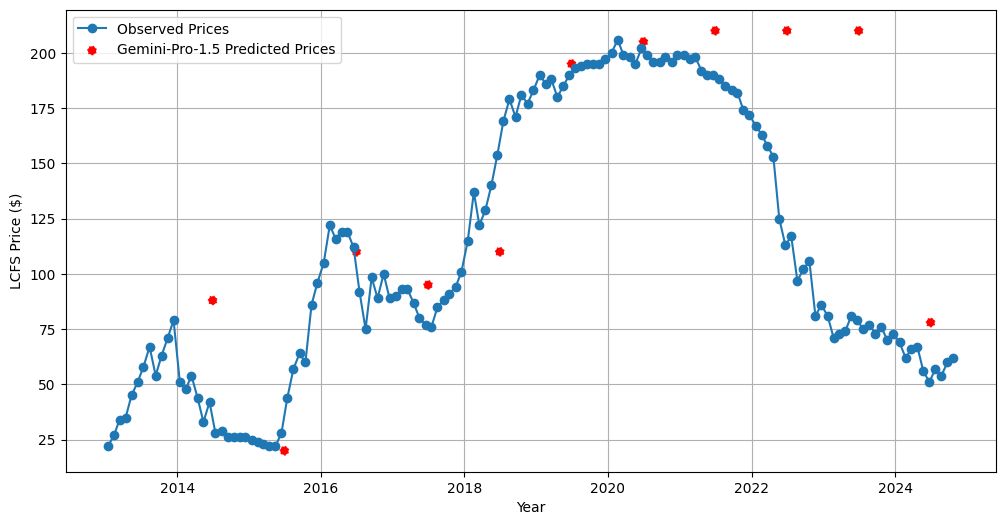

In [21]:
# Extract predicted prices and reasoning
predicted_prices = [pred['price'] for pred in predictions]
predicted_reasons = [pred['reason'] for pred in predictions]

# Get corresponding years for the predictions
dates = [pd.Timestamp(year=year, month=6, day=30) for year in range(start_year, end_year+1)]

# Ensure `start_index` matches the correct year range
start_index = lcfs[lcfs['Date'].dt.year >= 2012].index[0]

# Plot observed vs predicted prices
plt.figure(figsize=(12, 6))
plt.plot(lcfs['Date'], lcfs['Price'], label='Observed Prices', linestyle='-', marker='o')
plt.scatter(dates, predicted_prices, label='Gemini-Pro-1.5 Predicted Prices', color='r', linestyle=':')
plt.xlabel('Year')
plt.ylabel('LCFS Price ($)')
plt.legend()
plt.grid(True)
plt.savefig('/content/drive/MyDrive/0_2024_CarbonMarket_Sentiment/Long-term_prediction+reasoning/gemini_pred.png', dpi=300)
plt.show()

# Save predictions to CSV
df_predictions = pd.DataFrame({
    'Date': dates,
    'Predicted_Price': predicted_prices,
    'Reason': predicted_reasons
})
df_predictions.to_csv('/content/drive/MyDrive/0_2024_CarbonMarket_Sentiment/Long-term_prediction+reasoning/gemini_pred.csv', index=False)


# Claude 3.5

In [22]:
import anthropic
from typing import List, Dict, Any
import re


# Retrieve your API key
CLAUDE_API_KEY = userdata.get('CLAUDE_API_KEY')
client = anthropic.Anthropic(api_key=CLAUDE_API_KEY)

output_file = "/content/drive/MyDrive/0_2024_CarbonMarket_Sentiment/LCFS_task/price_pred_claude.csv"

In [23]:
import time
import random

def get_claude_response(api_key, role, prompt,
                       model: str = "claude-3-5-sonnet-20241022",
                       max_tokens: int = 8192) -> str:
  client = anthropic.Anthropic(api_key=api_key)

  response = client.messages.create(
      model=model,
      max_tokens=max_tokens,
      system=role,
      messages=prompt)
  return response.content[0].text

In [24]:
# Define the updated function to predict the next year's average LCFS price
def claude_predict_next_year(lcfs, news, monthly_data, yearly_data, start_year, end_year):
    result = []
    count   = 0
    predictions = []

    for year in range(start_year, end_year + 1):
        start_index = lcfs[lcfs['Date'].dt.year == year].index[0]

        # LCFS data
        current_date = lcfs['Date'].iloc[start_index]
        date_range = lcfs['Date'][:start_index]
        history_prices = lcfs['Price'][:start_index]
        history_volumes = lcfs['Volume'][:start_index]
        history_values = lcfs['Value'][:start_index]

        # relevent news
        relevant_news = news[news['date'] < current_date]
        news_to_current_date = "\n".join(
            f"Date: {row['date']}\nTitle: {row['title']}"
            for _, row in relevant_news.iterrows() )

        # History gas and diesel price
        history_gas_prices = monthly_data['Gas Price ($)'][:start_index]
        history_diesel_prices = monthly_data['Diesel Price ($)'][:start_index]

        # Yearly data
        year_index                  = yearly_data[yearly_data['Year'] == year].index[0]
        year_range                  = yearly_data['Year'][:year_index]
        historical_yearly           = yearly_data[yearly_data['Year'] < year]
        history_ev_sales            = historical_yearly['California EV Sales']
        history_ets                 = historical_yearly['EU ETS ($)']
        history_co2_emissions       = historical_yearly['California CO2 Emissions (MT)']
        history_CaT                 = historical_yearly['California CaT ($)']
        history_federal_fuel_charge = historical_yearly['Canada federal fuel charge ($)']


        # Create the prompt for LLM prediction
        role   =  (
                  f"You are an expert in carbon markets and LCFS price forecasting.\n"
                  f"Your task is to predict the **expected LCFS price** for the next year ({year}) by analyzing historical trends, economic factors, and policy influences.\n\n"

                  f"=== KEY CONSIDERATIONS ===\n"
                  f"1. **Historical Price Trends and Recent Transitions:** Ensure predictions reflect the long-term trend.\n"
                  f"2. **Market Effects:**\n"
                  f"   - More carbon credits being generated or granted → **LCFS price decreases**.\n"
                  f"   - Higher CO2 emissions and increased demand for credits → **LCFS price increases**.\n"
                  f"   - Investment in renewable energy → **More LCFS credits available → Price decreases**.\n"
                  f"3. **Economic & Market Drivers:**\n"
                  f"   - Higher carbon tax on gasoline increases gas prices which can reflects LCFS effect.\n"
                  f"   - Credit market adaptation over time introduces more credits, moderating excessive price rises.\n"
                  f"   - Cap-and-Trade, EU ETS, and external carbon markets may reflect LCFS pricing, but avoid assuming they always push prices up or down.\n"
                  f"4. **Sentiment & Policy Impact:**\n"
                  f"   - Policy changes should be evaluated carefully: Do they restrict credit supply (price up) or expand credit availability (price down)?\n"
                  f"   - Avoid assuming all regulatory updates lead to price increases—some may **reduce price volatility** by improving credit liquidity.\n\n"
                  f"5. **Handling Missing Data:** If any input is missing (NaN), you can ignore it for current calculations.\n"

                  f"=== OUTPUT FORMAT ===\n"
                  f"The predicted price should be a **single numeric value** (not a range or estimate for current task).\n"
                  f"(Price: <predicted_price>, Reason: <detailed explanation>)"
                  )

        prompt = [{"role": "user",
                   "content": (
                        f"=== HISTORICAL LCFS DATA ===\n"
                        f"- Dates: {list(date_range)}\n"
                        f"- Prices: {list(history_prices)}\n"
                        f"- Trading Volumes: {list(history_volumes)}\n"
                        f"- Market Values: {list(history_values)}\n\n"

                        f"=== HISTORICAL FUEL PRICE DATA ===\n"
                        f"- Gasoline Prices: {list(history_gas_prices)}\n"
                        f"- Diesel Prices: {list(history_diesel_prices)}\n\n"

                        f"=== RELEVANT NEWS BEFORE {year} ===\n"
                        f"{news_to_current_date}\n\n"

                        f"=== OTHER ECONOMIC & POLICY FACTORS ===\n"
                        f"- California CO2 emissions (MT): {list(history_co2_emissions)}\n"
                        f"- California Cap-and-Trade (CaT) prices: {list(history_CaT)}\n"
                        f"- California EV sales: {list(history_ev_sales)}\n"
                        f"- EU ETS carbon prices: {list(history_ets)}\n"
                        f"- Canada Federal Fuel Charge: {list(history_federal_fuel_charge)}\n\n"

                        f"=== TASK ===\n"
                        f"Predict the **expected LCFS price** for the next year ({year}) while considering:\n"
                        f"- The supply-demand balance of carbon credits and long-term trend on demand saturation.\n"
                        f"- The reflection of gas prices and related carbon taxation.\n"
                        f"- Carbon credit generation vs. demand from emissions and credential.\n"
                        f"- The development of clean energy increasing credit supply and lowering LCFS prices.\n"
                        f"- Policy changes that **both restrict and expand credit availability**.\n"
                        f"- Reflection from Cap-and-Trade, EU ETS, and external carbon market.\n\n"

                        f"Provide your forecast in this format:\n"
                        f"(Price: <predicted_price>, Reason: <detailed explanation>)"
                    )}]

        # Call the LLM API to generate a prediction
        # Get response from the model
        response = get_claude_response(
            api_key=CLAUDE_API_KEY,
            role=role,
            prompt=prompt)

        count += 1
        print(f"Processed promt: {count}")

        price = None
        reason = None

        try:
            # Extract the price string
            price_start = response.find("Price: ") + len("Price: ")
            price_end = response.find(",", price_start)
            price_str = response[price_start:price_end].strip()

            # Remove the dollar sign if present, and convert to float
            price = float(price_str.replace("$", "")) if "$" in price_str else float(price_str)

            # Extract the reasoning
            reason_start = response.find("Reason: ") + len("Reason: ")
            reason = response[reason_start:].strip()

            print(f"Extracted Price: {price}")
            print(f"Extracted Reason: {reason}")
        except Exception as e:
            print(f"Error processing response: {response}. Error: {e}")
            price = None
            reason = "Error in response format"

        # Append the predictions
        predictions.append({
            "year": year,
            "price": float(price),
            "reason": str(reason)})
    return predictions

In [25]:
# Run the updated function to make predictions
start_year = 2014
end_year = 2024
predictions = claude_predict_next_year(lcfs, all_news, monthly_data, yearly_data, start_year=start_year, end_year=end_year)

Processed promt: 1
Extracted Price: 85.0
Extracted Reason: While the strong 2013 upward trend suggests potential for higher prices, several factors indicate moderation: 1) Rapidly growing EV sales will increase credit generation, 2) New carbon capture projects will add to credit supply, 3) Stabilizing fuel prices reduce upward pressure, 4) Market maturation typically moderates extreme growth. The predicted 85.0 represents continued but moderated growth from the December 2013 price of 79.0, accounting for both structural demand and increasing credit supply. This 7.6% increase aligns with market maturation while reflecting California's commitment to emissions reduction.)
Processed promt: 2
Extracted Price: 31.0
Extracted Reason: The 2015 LCFS price is expected to moderately increase from the $26 level seen in late 2014 due to several factors: 1) The market has found stability after the 2014 correction, suggesting a price floor, 2) Growing EV sales will increase credit generation but won'

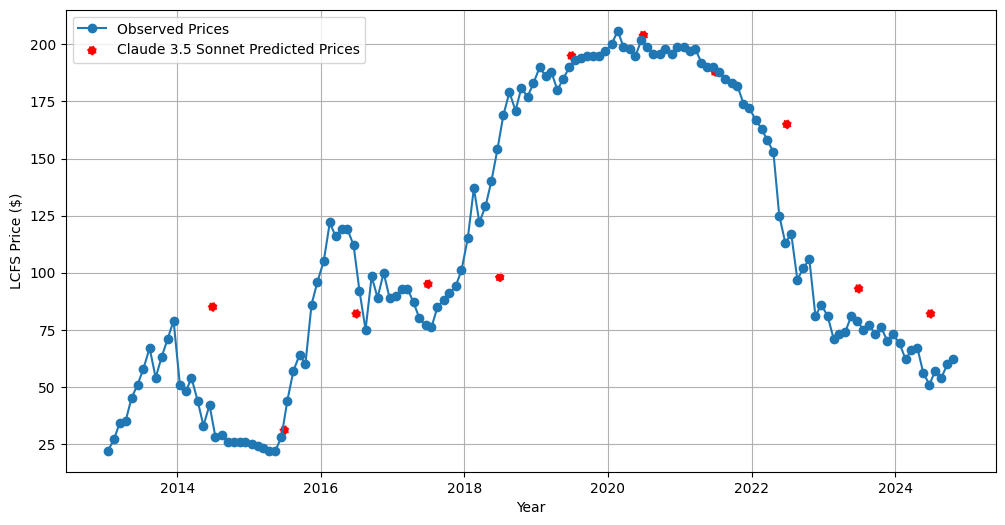

In [26]:
# Extract predicted prices and reasoning
predicted_prices = [pred['price'] for pred in predictions]
predicted_reasons = [pred['reason'] for pred in predictions]

# Get corresponding years for the predictions
dates = [pd.Timestamp(year=year, month=6, day=30) for year in range(start_year, end_year+1)]

# Ensure `start_index` matches the correct year range
start_index = lcfs[lcfs['Date'].dt.year >= 2012].index[0]

# Plot observed vs predicted prices
plt.figure(figsize=(12, 6))
plt.plot(lcfs['Date'], lcfs['Price'], label='Observed Prices', linestyle='-', marker='o')
plt.scatter(dates, predicted_prices, label='Claude 3.5 Sonnet Predicted Prices', color='r', linestyle=':')
plt.xlabel('Year')
plt.ylabel('LCFS Price ($)')
plt.legend()
plt.grid(True)
plt.savefig('/content/drive/MyDrive/0_2024_CarbonMarket_Sentiment/Long-term_prediction+reasoning/claude_pred.png', dpi=300)
plt.show()

# Save predictions to CSV
df_predictions = pd.DataFrame({
    'Date': dates,
    'Predicted_Price': predicted_prices,
    'Reason': predicted_reasons
})
df_predictions.to_csv('/content/drive/MyDrive/0_2024_CarbonMarket_Sentiment/Long-term_prediction+reasoning/claude_pred.csv', index=False)


# GPT-4o

In [27]:
import os
from openai import OpenAI
from google.colab import userdata
import pandas as pd
import json
import asyncio

output_file = "/content/drive/MyDrive/0_2024_CarbonMarket_Sentiment/Data_news/price_pred_gpt4o.csv"

# Retrieve your API key
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')

client = OpenAI.api_key=OPENAI_API_KEY


In [ ]:
# if necessary
pip install --upgrade --upgrade-strategy eager "regex" "charset-normalizer<4" "idna" "urllib3<3" "certifi" "requests" "anyio<5" "distro<2" "sniffio" "h11<0.15" "httpcore==1.*"  "annotated-types" "typing-extensions<5" "pydantic-core==2.27.1" "pydantic<3" "jiter<1" "tqdm" "colorama" "openai" "tiktoken" "httpx<0.28"

In [28]:
def gpt4o_generate_content(prompt):
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=prompt
        )
    return response.choices[0].message.content

In [29]:
from openai import OpenAI

client = OpenAI(api_key=OPENAI_API_KEY)

stream = client.chat.completions.create(
    messages=[
        {
            "role": "user",
            "content": "Say this is a test",
        }
    ],
    model="gpt-4o",
    stream=True,
)
for chunk in stream:
    print(chunk.choices[0].delta.content or "", end="")

This is a test. How can I assist you further?

In [30]:
# Define the updated function to predict the next year's average LCFS price
def gpt4o_predict_next_year(lcfs, news, monthly_data, yearly_data, start_year, end_year):
    result = []
    count   = 0
    predictions = []

    for year in range(start_year, end_year + 1):
        start_index = lcfs[lcfs['Date'].dt.year == year].index[0]

        # LCFS data
        current_date = lcfs['Date'].iloc[start_index]
        date_range = lcfs['Date'][:start_index]
        history_prices = lcfs['Price'][:start_index]
        history_volumes = lcfs['Volume'][:start_index]
        history_values = lcfs['Value'][:start_index]

        # relevent news
        relevant_news = news[news['date'] < current_date]
        news_to_current_date = "\n".join(
            f"Date: {row['date']}\nTitle: {row['title']}"
            for _, row in relevant_news.iterrows() )

        # History gas and diesel price
        history_gas_prices = monthly_data['Gas Price ($)'][:start_index]
        history_diesel_prices = monthly_data['Diesel Price ($)'][:start_index]

        # Yearly data
        year_index                  = yearly_data[yearly_data['Year'] == year].index[0]
        year_range                  = yearly_data['Year'][:year_index]
        historical_yearly           = yearly_data[yearly_data['Year'] < year]
        history_ev_sales            = historical_yearly['California EV Sales']
        history_ets                 = historical_yearly['EU ETS ($)']
        history_co2_emissions       = historical_yearly['California CO2 Emissions (MT)']
        history_CaT                 = historical_yearly['California CaT ($)']
        history_federal_fuel_charge = historical_yearly['Canada federal fuel charge ($)']


        # Create the prompt for LLM prediction
        prompt = [{"role": "system",
                   "content": (
                      f"You are an expert in carbon markets and LCFS price forecasting.\n"
                      f"Your task is to predict the **expected LCFS price** for the next year ({year}) by analyzing historical trends, economic factors, and policy influences.\n\n"

                      f"=== KEY CONSIDERATIONS ===\n"
                      f"1. **Historical Price Trends and Recent Transitions:** Ensure predictions reflect the long-term trend.\n"
                      f"2. **Market Effects:**\n"
                      f"   - More carbon credits being generated or granted → **LCFS price decreases**.\n"
                      f"   - Higher CO2 emissions and increased demand for credits → **LCFS price increases**.\n"
                      f"   - Investment in renewable energy → **More LCFS credits available → Price decreases**.\n"
                      f"3. **Economic & Market Drivers:**\n"
                      f"   - Higher carbon tax on gasoline increases gas prices which can reflects LCFS effect.\n"
                      f"   - Credit market adaptation over time introduces more credits, moderating excessive price rises.\n"
                      f"   - Cap-and-Trade, EU ETS, and external carbon markets may reflect LCFS pricing, but avoid assuming they always push prices up or down.\n"
                      f"4. **Sentiment & Policy Impact:**\n"
                      f"   - Policy changes should be evaluated carefully: Do they restrict credit supply (price up) or expand credit availability (price down)?\n"
                      f"   - Avoid assuming all regulatory updates lead to price increases—some may **reduce price volatility** by improving credit liquidity.\n\n"
                      f"5. **Handling Missing Data:** If any input is missing (NaN), you can ignore it for current calculations.\n"

                      f"=== OUTPUT FORMAT ===\n"
                      f"The predicted price should be a **single numeric value** (not a range or estimate for current task).\n"
                      f"(Price: <predicted_price>, Reason: <detailed explanation>)"
                      )
                   },
                  {"role": "user",
                   "content": (
                      f"=== HISTORICAL LCFS DATA ===\n"
                      f"- Dates: {list(date_range)}\n"
                      f"- Prices: {list(history_prices)}\n"
                      f"- Trading Volumes: {list(history_volumes)}\n"
                      f"- Market Values: {list(history_values)}\n\n"

                      f"=== HISTORICAL FUEL PRICE DATA ===\n"
                      f"- Gasoline Prices: {list(history_gas_prices)}\n"
                      f"- Diesel Prices: {list(history_diesel_prices)}\n\n"

                      f"=== RELEVANT NEWS BEFORE {year} ===\n"
                      f"{news_to_current_date}\n\n"

                      f"=== OTHER ECONOMIC & POLICY FACTORS ===\n"
                      f"- California CO2 emissions (MT): {list(history_co2_emissions)}\n"
                      f"- California Cap-and-Trade (CaT) prices: {list(history_CaT)}\n"
                      f"- California EV sales: {list(history_ev_sales)}\n"
                      f"- EU ETS carbon prices: {list(history_ets)}\n"
                      f"- Canada Federal Fuel Charge: {list(history_federal_fuel_charge)}\n\n"

                      f"=== TASK ===\n"
                      f"Predict the **expected LCFS price** for the next year ({year}) while considering:\n"
                      f"- The supply-demand balance of carbon credits and long-term trend on demand saturation.\n"
                      f"- The reflection of gas prices and related carbon taxation.\n"
                      f"- Carbon credit generation vs. demand from emissions and credential.\n"
                      f"- The development of clean energy increasing credit supply and lowering LCFS prices.\n"
                      f"- Policy changes that **both restrict and expand credit availability**.\n"
                      f"- Reflection from Cap-and-Trade, EU ETS, and external carbon market.\n\n"

                      f"Provide your forecast in this format:\n"
                      f"(Price: <predicted_price>, Reason: <detailed explanation>)"
                      )}
                  ]

        # Get response from the model
        response = gpt4o_generate_content(prompt)

        count += 1
        print(f"Processed promt: {count}")

        price = None
        reason = None

        try:
            # Extract the price string
            price_start = response.find("Price: ") + len("Price: ")
            price_end = response.find(",", price_start)
            price_str = response[price_start:price_end].strip()

            # Remove the dollar sign if present, and convert to float
            price = float(price_str.replace("$", "")) if "$" in price_str else float(price_str)

            # Extract the reasoning
            reason_start = response.find("Reason: ") + len("Reason: ")
            reason = response[reason_start:].strip()

            print(f"Extracted Price: {price}")
            print(f"Extracted Reason: {reason}")
        except Exception as e:
            print(f"Error processing response: {response}. Error: {e}")
            price = None
            reason = "Error in response format"

        # Append the predictions
        predictions.append({
            "year": year,
            "price": float(price),
            "reason": str(reason)})
    return predictions

In [31]:
# Run the updated function to make predictions
start_year = 2014
end_year = 2024
predictions = gpt4o_predict_next_year(lcfs, all_news, monthly_data, yearly_data, start_year=start_year, end_year=end_year)

Processed promt: 1
Extracted Price: 83.0
Extracted Reason: The 2013 LCFS prices showed a sharp upward trajectory, ending the year at $79 per credit from a starting point of $22 per credit. This increase suggests a growing demand for LCFS credits, likely driven by increased focus on emissions reductions and renewable energy adoption. The introduction of CO2-sequestration projects suggests an increasing effort to reduce emissions, which could increase CO2 credits' demand and thus drive up prices. Despite renewable energy advancements expanding credit supply, demand outpaced the supply, reflecting in higher prices. The increase in California EV sales represents a significant shift towards low-emission vehicles, potentially increasing credit supply slightly but not enough to offset demand increases. Gasoline prices remaining high towards the end of 2013 reflect higher fuel costs associated with carbon taxation effects, further nudging the LCFS prices upwards as the market expects these cos

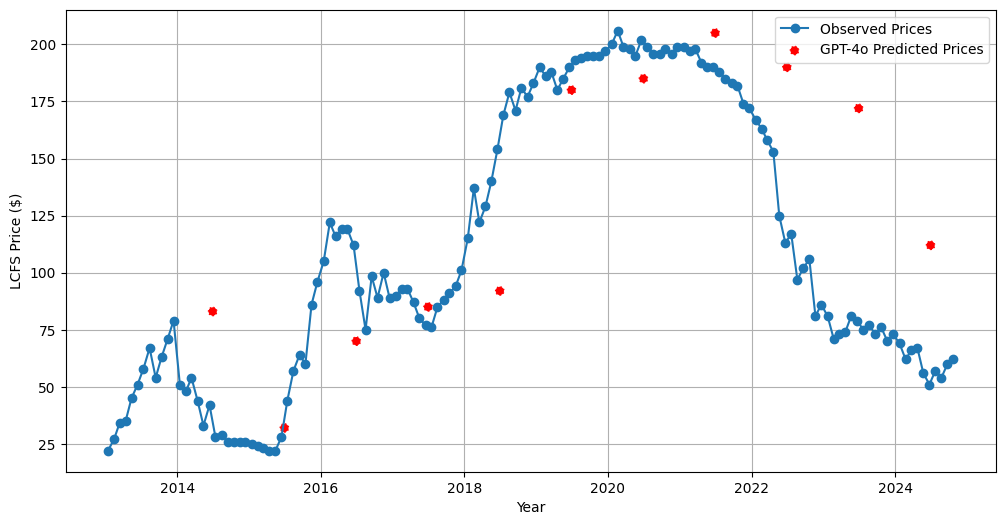

In [33]:
# Extract predicted prices and reasoning
predicted_prices = [pred['price'] for pred in predictions]
predicted_reasons = [pred['reason'] for pred in predictions]

# Get corresponding years for the predictions
dates = [pd.Timestamp(year=year, month=6, day=30) for year in range(start_year, end_year+1)]

# Ensure `start_index` matches the correct year range
start_index = lcfs[lcfs['Date'].dt.year >= 2012].index[0]

# Plot observed vs predicted prices
plt.figure(figsize=(12, 6))
plt.plot(lcfs['Date'], lcfs['Price'], label='Observed Prices', linestyle='-', marker='o')
plt.scatter(dates, predicted_prices, label='GPT-4o Predicted Prices', color='r', linestyle=':')
plt.xlabel('Year')
plt.ylabel('LCFS Price ($)')
plt.legend()
plt.grid(True)
plt.savefig('/content/drive/MyDrive/0_2024_CarbonMarket_Sentiment/Long-term_prediction+reasoning/gpt-4o_pred.png', dpi=300)
plt.show()

# Save predictions to CSV
df_predictions = pd.DataFrame({
    'Date': dates,
    'Predicted_Price': predicted_prices,
    'Reason': predicted_reasons
})
df_predictions.to_csv('/content/drive/MyDrive/0_2024_CarbonMarket_Sentiment/Long-term_prediction+reasoning/gpt-4o_pred.csv', index=False)


# o1-preview

In [34]:
def o1_generate_content(prompt):
    response = client.chat.completions.create(
        model="o1-preview",
        messages=[
        {
            "role": "user",
            "content": prompt
        }
    ]
    )
    return response.choices[0].message.content.strip()


In [38]:
# Define the updated function to predict the next year's average LCFS price
def o1_predict_next_year(lcfs, news, monthly_data, yearly_data, start_year, end_year):
    result = []
    count   = 0
    predictions = []

    for year in range(start_year, end_year + 1):
        start_index = lcfs[lcfs['Date'].dt.year == year].index[0]

        # LCFS data
        current_date = lcfs['Date'].iloc[start_index]
        date_range = lcfs['Date'][:start_index]
        history_prices = lcfs['Price'][:start_index]
        history_volumes = lcfs['Volume'][:start_index]
        history_values = lcfs['Value'][:start_index]

        # relevent news
        relevant_news = news[news['date'] < current_date]
        news_to_current_date = "\n".join(
            f"Date: {row['date']}\nTitle: {row['title']}"
            for _, row in relevant_news.iterrows() )

        # History gas and diesel price
        history_gas_prices = monthly_data['Gas Price ($)'][:start_index]
        history_diesel_prices = monthly_data['Diesel Price ($)'][:start_index]

        # Yearly data
        year_index                  = yearly_data[yearly_data['Year'] == year].index[0]
        year_range                  = yearly_data['Year'][:year_index]
        historical_yearly           = yearly_data[yearly_data['Year'] < year]
        history_ev_sales            = historical_yearly['California EV Sales']
        history_ets                 = historical_yearly['EU ETS ($)']
        history_co2_emissions       = historical_yearly['California CO2 Emissions (MT)']
        history_CaT                 = historical_yearly['California CaT ($)']
        history_federal_fuel_charge = historical_yearly['Canada federal fuel charge ($)']


        # Create the prompt for LLM prediction
        prompt = (
                  f"You are an expert in carbon markets and LCFS price forecasting.\n"
                  f"Your task is to predict the **expected LCFS price** for the next year ({year}) by analyzing historical trends, economic factors, and policy influences.\n\n"

                  f"=== KEY CONSIDERATIONS ===\n"
                  f"1. **Historical Price Trends and Recent Transitions:** Ensure predictions reflect the long-term trend.\n"
                  f"2. **Market Effects:**\n"
                  f"   - More carbon credits being generated or granted → **LCFS price decreases**.\n"
                  f"   - Higher CO2 emissions and increased demand for credits → **LCFS price increases**.\n"
                  f"   - Investment in renewable energy → **More LCFS credits available → Price decreases**.\n"
                  f"3. **Economic & Market Drivers:**\n"
                  f"   - Higher carbon tax on gasoline increases gas prices which can reflects LCFS effect.\n"
                  f"   - Credit market adaptation over time introduces more credits, moderating excessive price rises.\n"
                  f"   - Cap-and-Trade, EU ETS, and external carbon markets may reflect LCFS pricing, but avoid assuming they always push prices up or down.\n"
                  f"4. **Sentiment & Policy Impact:**\n"
                  f"   - Policy changes should be evaluated carefully: Do they restrict credit supply (price up) or expand credit availability (price down)?\n"
                  f"   - Avoid assuming all regulatory updates lead to price increases—some may **reduce price volatility** by improving credit liquidity.\n\n"
                  f"5. **Handling Missing Data:** If any input is missing (NaN), you can ignore it for current calculations.\n"

                  f"=== OUTPUT FORMAT ===\n"
                  f"The predicted price should be a **single numeric value** (not a range or estimate for current task).\n"
                  f"(Price: <predicted_price>, Reason: <detailed explanation>)"

                  f"=== HISTORICAL LCFS DATA ===\n"
                  f"- Dates: {list(date_range)}\n"
                  f"- Prices: {list(history_prices)}\n"
                  f"- Trading Volumes: {list(history_volumes)}\n"
                  f"- Market Values: {list(history_values)}\n\n"

                  f"=== HISTORICAL FUEL PRICE DATA ===\n"
                  f"- Gasoline Prices: {list(history_gas_prices)}\n"
                  f"- Diesel Prices: {list(history_diesel_prices)}\n\n"

                  f"=== RELEVANT NEWS BEFORE {year} ===\n"
                  f"{news_to_current_date}\n\n"

                  f"=== OTHER ECONOMIC & POLICY FACTORS ===\n"
                  f"- California CO2 emissions (MT): {list(history_co2_emissions)}\n"
                  f"- California Cap-and-Trade (CaT) prices: {list(history_CaT)}\n"
                  f"- California EV sales: {list(history_ev_sales)}\n"
                  f"- EU ETS carbon prices: {list(history_ets)}\n"
                  f"- Canada Federal Fuel Charge: {list(history_federal_fuel_charge)}\n\n"

                  f"=== TASK ===\n"
                  f"Predict the **expected LCFS price** for the next year ({year}) while considering:\n"
                  f"- The supply-demand balance of carbon credits and long-term trend on demand saturation.\n"
                  f"- The reflection of gas prices and related carbon taxation.\n"
                  f"- Carbon credit generation vs. demand from emissions and credential.\n"
                  f"- The development of clean energy increasing credit supply and lowering LCFS prices.\n"
                  f"- Policy changes that **both restrict and expand credit availability**.\n"
                  f"- Reflection from Cap-and-Trade, EU ETS, and external carbon market.\n\n"

                  f"Provide your forecast in this format:\n"
                  f"(Price: <a single numeric value>, Reason: <detailed explanation>)"
                  )

        # Get response from the model
        response = o1_generate_content(prompt)

        count += 1
        print(f"Processed promt: {count}")

        price = None
        reason = None

        try:
            # Extract the price string
            price_start = response.find("Price: ") + len("Price: ")
            price_end = response.find(",", price_start)
            price_str = response[price_start:price_end].strip()

            # Remove the dollar sign if present, and convert to float
            price = float(price_str.replace("$", "")) if "$" in price_str else float(price_str)

            # Extract the reasoning
            reason_start = response.find("Reason: ") + len("Reason: ")
            reason = response[reason_start:].strip()

            print(f"Extracted Price: {price}")
            print(f"Extracted Reason: {reason}")
        except Exception as e:
            print(f"Error processing response: {response}. Error: {e}")
            price = None
            reason = "Error in response format"

        # Append the predictions
        predictions.append({
            "year": year,
            "price": float(price),
            "reason": str(reason)})
    return predictions

In [39]:
# Run the updated function to make predictions
start_year = 2014
end_year = 2024
predictions = o1_predict_next_year(lcfs, all_news, monthly_data, yearly_data, start_year=start_year, end_year=end_year)

Processed promt: 1
Extracted Price: 95.0
Extracted Reason: Based on the significant upward trend in LCFS prices during 2013—from \$22 in January to \$79 in December—it's apparent that demand for credits was outpacing supply, leading to price increases. However, several factors in 2014 are expected to influence this dynamic:

1. **Increased Credit Supply**: Investment in renewable energy and a surge in electric vehicle (EV) sales in California (from 6,743 units in 2011 to 39,805 units in 2013) are likely to generate more LCFS credits. This increase in credit supply will put downward pressure on prices.

2. **Market Adaptation**: As the LCFS market matures, mechanisms for generating and trading credits become more efficient, introducing more credits into the market and helping to moderate excessive price rises.

3. **Emission Trends**: California's CO2 emissions have been slightly decreasing (from 437.4 MT in 2011 to 431.4 MT in 2013), which may reduce the demand for credits as fewer emi

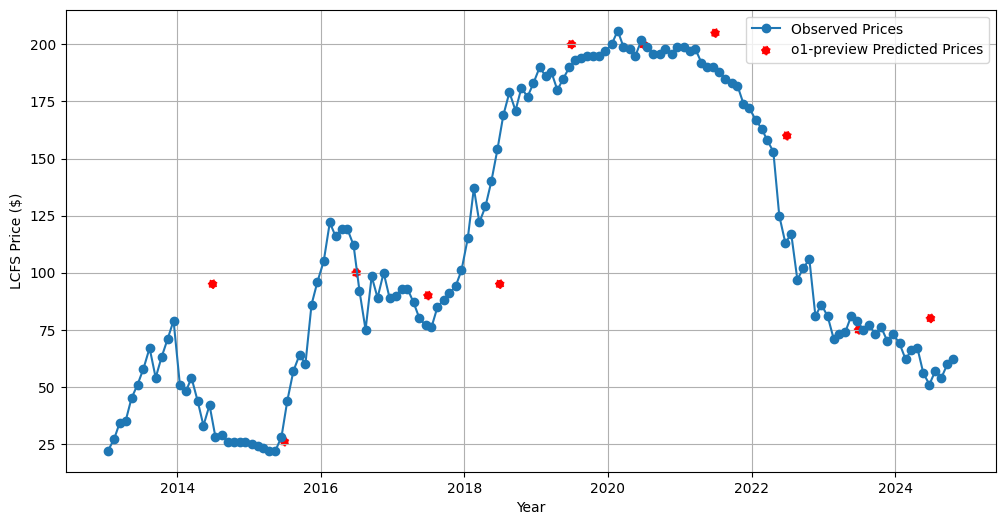

In [43]:
# Extract predicted prices and reasoning
predicted_prices = [pred['price'] for pred in predictions]
predicted_reasons = [pred['reason'] for pred in predictions]

# Get corresponding years for the predictions
dates = [pd.Timestamp(year=year, month=6, day=30) for year in range(start_year, end_year+1)]

# Ensure `start_index` matches the correct year range
start_index = lcfs[lcfs['Date'].dt.year >= 2012].index[0]

# Plot observed vs predicted prices
plt.figure(figsize=(12, 6))
plt.plot(lcfs['Date'], lcfs['Price'], label='Observed Prices', linestyle='-', marker='o')
plt.scatter(dates, predicted_prices, label='o1-preview Predicted Prices', color='r', linestyle=':')
plt.xlabel('Year')
plt.ylabel('LCFS Price ($)')
plt.legend()
plt.grid(True)
plt.savefig('/content/drive/MyDrive/0_2024_CarbonMarket_Sentiment/Long-term_prediction+reasoning/o1_pred.png', dpi=300)
plt.show()

# Save predictions to CSV
df_predictions = pd.DataFrame({
    'Date': dates,
    'Predicted_Price': predicted_prices,
    'Reason': predicted_reasons
})
df_predictions.to_csv('/content/drive/MyDrive/0_2024_CarbonMarket_Sentiment/Long-term_prediction+reasoning/o1_pred.csv', index=False)


# Claude as the judge looking at all the inputs

In [45]:
# Specify the file paths
file_paths = [
    '/content/drive/MyDrive/0_2024_CarbonMarket_Sentiment/Long-term_prediction+reasoning/gemini_pred.csv',
    '/content/drive/MyDrive/0_2024_CarbonMarket_Sentiment/Long-term_prediction+reasoning/gpt-4o_pred.csv',
    '/content/drive/MyDrive/0_2024_CarbonMarket_Sentiment/Long-term_prediction+reasoning/o1_pred.csv',
    '/content/drive/MyDrive/0_2024_CarbonMarket_Sentiment/Long-term_prediction+reasoning/claude_pred.csv'
]

df_gemini = pd.read_csv('/content/drive/MyDrive/0_2024_CarbonMarket_Sentiment/Long-term_prediction+reasoning/gemini_pred.csv')
df_gpt4o = pd.read_csv('/content/drive/MyDrive/0_2024_CarbonMarket_Sentiment/Long-term_prediction+reasoning/gpt-4o_pred.csv')
df_o1 = pd.read_csv('/content/drive/MyDrive/0_2024_CarbonMarket_Sentiment/Long-term_prediction+reasoning/o1_pred.csv')
df_claude = pd.read_csv('/content/drive/MyDrive/0_2024_CarbonMarket_Sentiment/Long-term_prediction+reasoning/claude_pred.csv')

df_gemini['Date'] = pd.to_datetime(df_gemini['Date'])
df_gpt4o['Date'] = pd.to_datetime(df_gpt4o['Date'])
df_o1['Date'] = pd.to_datetime(df_o1['Date'])
df_claude['Date'] = pd.to_datetime(df_claude['Date'])

In [46]:
df_gemini

,Date,Predicted_Price,Reason
0,2014-06-30,88.0,The LCFS price has shown a clear upward trend ...
1,2015-06-30,20.0,The LCFS price for 2015 is predicted to be aro...
2,2016-06-30,110.0,The LCFS price in 2016 is predicted to be $110...
3,2017-06-30,95.0,The LCFS price in 2017 is predicted to be arou...
4,2018-06-30,110.0,The LCFS price for 2018 is predicted to be aro...
5,2019-06-30,195.0,Several factors point to a continued price inc...
6,2020-06-30,205.0,The LCFS price in 2020 is predicted to be arou...
7,2021-06-30,210.0,The LCFS price in 2020 hovered around $200. S...
8,2022-06-30,210.0,"The LCFS price in 2021 hovered around $200, de..."
9,2023-06-30,210.0,The LCFS price is expected to continue its upw...


In [57]:
float(df_gemini[df_gemini['Date'].dt.year ==2015]['Predicted_Price'].iloc[0])

20.0

In [59]:
str(df_gemini[df_gemini['Date'].dt.year ==2015]['Reason'].iloc[0])

"The LCFS price for 2015 is predicted to be around 20, reflecting a continuing downward trend observed in the latter half of 2014. Several factors contribute to this prediction:\n\n* **Declining Trend:** The LCFS price showed a clear decline from a peak of 79 in late 2013 to 26 by the end of 2014.  This suggests increasing credit generation and potentially weakening demand, a trend likely to continue into 2015.  This stabilization around 26 suggests a potential floor, but further downward pressure is anticipated.\n\n* **Clean Energy and Credit Supply:**  News items related to CO2 sequestration and energy-efficient technologies, coupled with rising EV sales in California, point towards an increase in the supply of LCFS credits.  This increased availability of credits will exert downward pressure on the price.\n\n* **Market Adaptation and Saturation:** The initial high prices likely incentivized significant investment in low-carbon fuel production and technology, leading to increased cre

Use Claude to make summary

In [60]:
# Define the updated function to predict the next year's average LCFS price
def claude_predict_summary(lcfs, news, monthly_data, yearly_data, df_gemini, df_gpt4o, df_o1, df_claude, start_year, end_year):
    result = []
    count   = 0
    predictions = []

    for year in range(start_year, end_year + 1):
        start_index = lcfs[lcfs['Date'].dt.year == year].index[0]

        # LCFS data
        current_date = lcfs['Date'].iloc[start_index]
        date_range = lcfs['Date'][:start_index]
        history_prices = lcfs['Price'][:start_index]
        history_volumes = lcfs['Volume'][:start_index]
        history_values = lcfs['Value'][:start_index]

        # relevent news
        relevant_news = news[news['date'] < current_date]
        news_to_current_date = "\n".join(
            f"Date: {row['date']}\nTitle: {row['title']}"
            for _, row in relevant_news.iterrows() )

        # History gas and diesel price
        history_gas_prices = monthly_data['Gas Price ($)'][:start_index]
        history_diesel_prices = monthly_data['Diesel Price ($)'][:start_index]

        # Yearly data
        year_index                  = yearly_data[yearly_data['Year'] == year].index[0]
        year_range                  = yearly_data['Year'][:year_index]
        historical_yearly           = yearly_data[yearly_data['Year'] < year]
        history_ev_sales            = historical_yearly['California EV Sales']
        history_ets                 = historical_yearly['EU ETS ($)']
        history_co2_emissions       = historical_yearly['California CO2 Emissions (MT)']
        history_CaT                 = historical_yearly['California CaT ($)']
        history_federal_fuel_charge = historical_yearly['Canada federal fuel charge ($)']

        # exsiting predictions
        gemini_pred = df_gemini[df_gemini['Date'].dt.year ==year]
        gpt4o_pred  = df_gpt4o[df_gpt4o['Date'].dt.year ==year]
        o1_pred     = df_o1[df_o1['Date'].dt.year ==year]
        claude_pred = df_claude[df_claude['Date'].dt.year ==year]

        gemini_predicted_price = float(gemini_pred['Predicted_Price'].iloc[0])
        gemini_reason          = str(gemini_pred['Reason'].iloc[0])
        gpt4o_predicted_price  = float(gpt4o_pred['Predicted_Price'].iloc[0])
        gpt4o_reason           = str(gpt4o_pred['Reason'].iloc[0])
        o1_predicted_price     = float(o1_pred['Predicted_Price'].iloc[0])
        o1_reason              = str(o1_pred['Reason'].iloc[0])
        claude_predicted_price = float(claude_pred['Predicted_Price'].iloc[0])
        claude_reason          = str(claude_pred['Reason'].iloc[0])

        # Create the prompt for LLM prediction
        role   =  (
                  f"You are an expert in carbon markets and LCFS price forecasting.\n"
                  f"Your task is to predict the **expected LCFS price** for the next year ({year}).\n"
                  f"You will accomplish this task by judge previous predictions from all the experts and their reasoning (including yours) and analyzing historical trends, economic factors, policy influences.\n\n"

                  f"=== KEY CONSIDERATIONS ===\n"
                  f"1. **Historical Price Trends and Recent Transitions:** Ensure predictions reflect the long-term trend.\n"
                  f"2. **Market Effects:**\n"
                  f"   - More carbon credits being generated or granted → **LCFS price decreases**.\n"
                  f"   - Higher CO2 emissions and increased demand for credits → **LCFS price increases**.\n"
                  f"   - Investment in renewable energy → **More LCFS credits available → Price decreases**.\n"
                  f"3. **Economic & Market Drivers:**\n"
                  f"   - Higher carbon tax on gasoline increases gas prices which can reflects LCFS effect.\n"
                  f"   - Credit market adaptation over time introduces more credits, moderating excessive price rises.\n"
                  f"   - Cap-and-Trade, EU ETS, and external carbon markets may reflect LCFS pricing, but avoid assuming they always push prices up or down.\n"
                  f"4. **Sentiment & Policy Impact:**\n"
                  f"   - Policy changes should be evaluated carefully: Do they restrict credit supply (price up) or expand credit availability (price down)?\n"
                  f"   - Avoid assuming all regulatory updates lead to price increases—some may **reduce price volatility** by improving credit liquidity.\n\n"
                  f"5. **Judge Other Experts' Prediction:**\n"
                  f"   - You are also provided with predictions and reasoning from other experts (including yours previous).\n"
                  f"   - Compare and contrast reasoning to admit correctness and identify inconsistencies in their assessments.\n"
                  f"   - Taking all the insights, then make an independent, final decision based on all the considerations.\n"
                  f"6. **Handling Missing Data:** If any input is missing (NaN), you can ignore it for current calculations.\n"

                  f"=== OUTPUT FORMAT ===\n"
                  f"The predicted price should be a **single numeric value** (not a range or estimate for current task).\n"
                  f"(Price: <predicted_price>, Reason: <detailed explanation>)"
                  )

        prompt = [{"role": "user",
                   "content": (
                        f"=== HISTORICAL LCFS DATA ===\n"
                        f"- Dates: {list(date_range)}\n"
                        f"- Prices: {list(history_prices)}\n"
                        f"- Trading Volumes: {list(history_volumes)}\n"
                        f"- Market Values: {list(history_values)}\n\n"

                        f"=== HISTORICAL FUEL PRICE DATA ===\n"
                        f"- Gasoline Prices: {list(history_gas_prices)}\n"
                        f"- Diesel Prices: {list(history_diesel_prices)}\n\n"

                        f"=== RELEVANT NEWS BEFORE {year} ===\n"
                        f"{news_to_current_date}\n\n"

                        f"=== OTHER ECONOMIC & POLICY FACTORS ===\n"
                        f"- California CO2 emissions (MT): {list(history_co2_emissions)}\n"
                        f"- California Cap-and-Trade (CaT) prices: {list(history_CaT)}\n"
                        f"- California EV sales: {list(history_ev_sales)}\n"
                        f"- EU ETS carbon prices: {list(history_ets)}\n"
                        f"- Canada Federal Fuel Charge: {list(history_federal_fuel_charge)}\n\n"

                        f"=== PREVIOUS PREDICTIONS & REASON ===\n"
                        f"**Expert A Prediction:**\n"
                        f"- Price: {gemini_predicted_price}\n"
                        f"- Reason: {gemini_reason}\n\n"

                        f"**Expert B Prediction:**\n"
                        f"- Price: {gpt4o_predicted_price}\n"
                        f"- Reason: {gpt4o_reason}\n\n"

                        f"**Expert C Prediction:**\n"
                        f"- Price: {o1_predicted_price}\n"
                        f"- Reason: {o1_reason}\n\n"

                        f"**Your Previous Prediction:**\n"
                        f"- Price: {claude_predicted_price}\n"
                        f"- Reason: {claude_reason}\n\n"

                        f"=== TASK ===\n"
                        f"Predict the **expected LCFS price** for the next year ({year}) while considering:\n"
                        f"- The supply-demand balance of carbon credits and long-term trend on demand saturation.\n"
                        f"- The reflection of gas prices and related carbon taxation.\n"
                        f"- Carbon credit generation vs. demand from emissions and credential.\n"
                        f"- The development of clean energy increasing credit supply and lowering LCFS prices.\n"
                        f"- Policy changes that **both restrict and expand credit availability**.\n"
                        f"- Reflection from Cap-and-Trade, EU ETS, and external carbon market.\n"
                        f"- Your previous and other experts' predictions and insight.\n\n"

                        f"Provide your forecast in this format:\n"
                        f"(Price: <predicted_price>, Reason: <detailed explanation>)"
                    )}]

        # Call the LLM API to generate a prediction
        # Get response from the model
        response = get_claude_response(
            api_key=CLAUDE_API_KEY,
            role=role,
            prompt=prompt)

        count += 1
        print(f"Processed promt: {count}")

        price = None
        reason = None

        try:
            # Extract the price string
            price_start = response.find("Price: ") + len("Price: ")
            price_end = response.find(",", price_start)
            price_str = response[price_start:price_end].strip()

            # Remove the dollar sign if present, and convert to float
            price = float(price_str.replace("$", "")) if "$" in price_str else float(price_str)

            # Extract the reasoning
            reason_start = response.find("Reason: ") + len("Reason: ")
            reason = response[reason_start:].strip()

            print(f"Extracted Price: {price}")
            print(f"Extracted Reason: {reason}")
        except Exception as e:
            print(f"Error processing response: {response}. Error: {e}")
            price = None
            reason = "Error in response format"

        # Append the predictions
        predictions.append({
            "year": year,
            "price": float(price),
            "reason": str(reason)})
    return predictions

In [62]:
# Run the updated function to make predictions
start_year = 2014
end_year = 2024
predictions = claude_predict_summary(lcfs, all_news, monthly_data, yearly_data, df_gemini, df_gpt4o, df_o1, df_claude, start_year=start_year, end_year=end_year)

Processed promt: 1
Extracted Price: 86.5
Extracted Reason: After careful consideration of historical data, other expert predictions, and various market factors, I'm adjusting my prediction to $86.5 for 2014. Here's the detailed reasoning:

1. **Historical Trend Analysis:**
- The 2013 price trend shows steady growth from $22 to $79, representing a 259% annual increase
- However, the monthly growth rate decreased in later months, suggesting market maturation
- Trading volumes were particularly high in September and November 2013, indicating increased market liquidity

2. **Expert Consensus Analysis:**
- The range of expert predictions (83-95) suggests general agreement on continued but moderated growth
- Expert A ($88) and B ($83) provide reasonable arguments about market maturation
- Expert C's higher prediction ($95) may overestimate the impact of demand despite valid points about market fundamentals

3. **Supply-Side Factors:**
- California EV sales showed explosive growth (491% from 

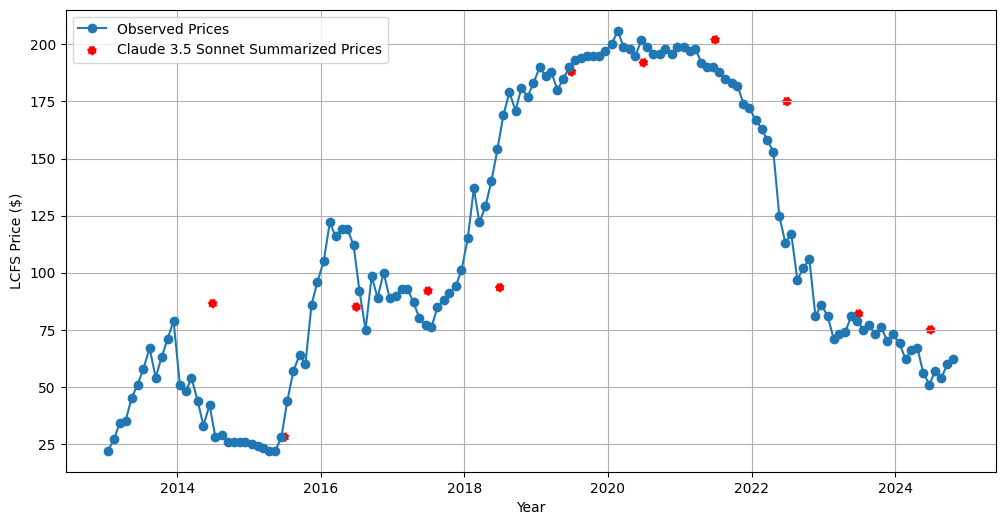

In [63]:
# Extract predicted prices and reasoning
predicted_prices = [pred['price'] for pred in predictions]
predicted_reasons = [pred['reason'] for pred in predictions]

# Get corresponding years for the predictions
dates = [pd.Timestamp(year=year, month=6, day=30) for year in range(start_year, end_year+1)]

# Ensure `start_index` matches the correct year range
start_index = lcfs[lcfs['Date'].dt.year >= 2012].index[0]

# Plot observed vs predicted prices
plt.figure(figsize=(12, 6))
plt.plot(lcfs['Date'], lcfs['Price'], label='Observed Prices', linestyle='-', marker='o')
plt.scatter(dates, predicted_prices, label='Claude 3.5 Sonnet Summarized Prices', color='r', linestyle=':')
plt.xlabel('Year')
plt.ylabel('LCFS Price ($)')
plt.legend()
plt.grid(True)
plt.savefig('/content/drive/MyDrive/0_2024_CarbonMarket_Sentiment/Long-term_prediction+reasoning/claude_summary.png', dpi=300)
plt.show()

# Save predictions to CSV
df_predictions = pd.DataFrame({
    'Date': dates,
    'Predicted_Price': predicted_prices,
    'Reason': predicted_reasons
})
df_predictions.to_csv('/content/drive/MyDrive/0_2024_CarbonMarket_Sentiment/Long-term_prediction+reasoning/claude_summary.csv', index=False)


Use o1 to make summary

In [67]:
# Define the updated function to predict the next year's average LCFS price
def o1_predict_summary(lcfs, news, monthly_data, yearly_data, df_gemini, df_gpt4o, df_o1, df_claude, start_year, end_year):
    result = []
    count   = 0
    predictions = []

    for year in range(start_year, end_year + 1):
        start_index = lcfs[lcfs['Date'].dt.year == year].index[0]

        # LCFS data
        current_date = lcfs['Date'].iloc[start_index]
        date_range = lcfs['Date'][:start_index]
        history_prices = lcfs['Price'][:start_index]
        history_volumes = lcfs['Volume'][:start_index]
        history_values = lcfs['Value'][:start_index]

        # relevent news
        relevant_news = news[news['date'] < current_date]
        news_to_current_date = "\n".join(
            f"Date: {row['date']}\nTitle: {row['title']}"
            for _, row in relevant_news.iterrows() )

        # History gas and diesel price
        history_gas_prices = monthly_data['Gas Price ($)'][:start_index]
        history_diesel_prices = monthly_data['Diesel Price ($)'][:start_index]

        # Yearly data
        year_index                  = yearly_data[yearly_data['Year'] == year].index[0]
        year_range                  = yearly_data['Year'][:year_index]
        historical_yearly           = yearly_data[yearly_data['Year'] < year]
        history_ev_sales            = historical_yearly['California EV Sales']
        history_ets                 = historical_yearly['EU ETS ($)']
        history_co2_emissions       = historical_yearly['California CO2 Emissions (MT)']
        history_CaT                 = historical_yearly['California CaT ($)']
        history_federal_fuel_charge = historical_yearly['Canada federal fuel charge ($)']

        # exsiting predictions
        gemini_pred = df_gemini[df_gemini['Date'].dt.year ==year]
        gpt4o_pred  = df_gpt4o[df_gpt4o['Date'].dt.year ==year]
        o1_pred     = df_o1[df_o1['Date'].dt.year ==year]
        claude_pred = df_claude[df_claude['Date'].dt.year ==year]

        gemini_predicted_price = float(gemini_pred['Predicted_Price'].iloc[0])
        gemini_reason          = str(gemini_pred['Reason'].iloc[0])
        gpt4o_predicted_price  = float(gpt4o_pred['Predicted_Price'].iloc[0])
        gpt4o_reason           = str(gpt4o_pred['Reason'].iloc[0])
        o1_predicted_price     = float(o1_pred['Predicted_Price'].iloc[0])
        o1_reason              = str(o1_pred['Reason'].iloc[0])
        claude_predicted_price = float(claude_pred['Predicted_Price'].iloc[0])
        claude_reason          = str(claude_pred['Reason'].iloc[0])


        # Create the prompt for LLM prediction
        prompt = (
                  f"You are an expert in carbon markets and LCFS price forecasting.\n"
                  f"Your task is to predict the **expected LCFS price** for the next year ({year}).\n"
                  f"You will accomplish this task by judge previous predictions from all the experts and their reasoning (including yours) and analyzing historical trends, economic factors, policy influences.\n\n"

                  f"=== KEY CONSIDERATIONS ===\n"
                  f"1. **Historical Price Trends and Recent Transitions:** Ensure predictions reflect the long-term trend.\n"
                  f"2. **Market Effects:**\n"
                  f"   - More carbon credits being generated or granted → **LCFS price decreases**.\n"
                  f"   - Higher CO2 emissions and increased demand for credits → **LCFS price increases**.\n"
                  f"   - Investment in renewable energy → **More LCFS credits available → Price decreases**.\n"
                  f"3. **Economic & Market Drivers:**\n"
                  f"   - Higher carbon tax on gasoline increases gas prices which can reflects LCFS effect.\n"
                  f"   - Credit market adaptation over time introduces more credits, moderating excessive price rises.\n"
                  f"   - Cap-and-Trade, EU ETS, and external carbon markets may reflect LCFS pricing, but avoid assuming they always push prices up or down.\n"
                  f"4. **Sentiment & Policy Impact:**\n"
                  f"   - Policy changes should be evaluated carefully: Do they restrict credit supply (price up) or expand credit availability (price down)?\n"
                  f"   - Avoid assuming all regulatory updates lead to price increases—some may **reduce price volatility** by improving credit liquidity.\n\n"
                  f"5. **Judge Other Experts' Prediction:**\n"
                  f"   - You are also provided with predictions and reasoning from other experts (including yours previous).\n"
                  f"   - Compare and contrast reasoning to admit correctness and identify inconsistencies in their assessments.\n"
                  f"   - Taking all the insights, then make an independent, final decision based on all the considerations.\n"
                  f"6. **Handling Missing Data:** If any input is missing (NaN), you can ignore it for current calculations.\n"

                  f"=== OUTPUT FORMAT ===\n"
                  f"The predicted price should be a **single numeric value** (not a range or estimate for current task).\n"
                  f"(Price: <predicted_price>, Reason: <detailed explanation>)"

                  f"=== HISTORICAL LCFS DATA ===\n"
                  f"- Dates: {list(date_range)}\n"
                  f"- Prices: {list(history_prices)}\n"
                  f"- Trading Volumes: {list(history_volumes)}\n"
                  f"- Market Values: {list(history_values)}\n\n"

                  f"=== HISTORICAL FUEL PRICE DATA ===\n"
                  f"- Gasoline Prices: {list(history_gas_prices)}\n"
                  f"- Diesel Prices: {list(history_diesel_prices)}\n\n"

                  f"=== RELEVANT NEWS BEFORE {year} ===\n"
                  f"{news_to_current_date}\n\n"

                  f"=== OTHER ECONOMIC & POLICY FACTORS ===\n"
                  f"- California CO2 emissions (MT): {list(history_co2_emissions)}\n"
                  f"- California Cap-and-Trade (CaT) prices: {list(history_CaT)}\n"
                  f"- California EV sales: {list(history_ev_sales)}\n"
                  f"- EU ETS carbon prices: {list(history_ets)}\n"
                  f"- Canada Federal Fuel Charge: {list(history_federal_fuel_charge)}\n\n"

                  f"=== PREVIOUS PREDICTIONS & REASON ===\n"
                  f"**Expert A Prediction:**\n"
                  f"- Price: {gemini_predicted_price}\n"
                  f"- Reason: {gemini_reason}\n\n"

                  f"**Expert B Prediction:**\n"
                  f"- Price: {gpt4o_predicted_price}\n"
                  f"- Reason: {gpt4o_reason}\n\n"

                  f"**Expert C Prediction:**\n"
                  f"- Price: {claude_predicted_price}\n"
                  f"- Reason: {claude_reason}\n\n"

                  f"**Your Previous Prediction:**\n"
                  f"- Price: {o1_predicted_price}\n"
                  f"- Reason: {o1_reason}\n\n"

                  f"=== TASK ===\n"
                  f"Predict the **expected LCFS price** for the next year ({year}) while considering:\n"
                  f"- The supply-demand balance of carbon credits and long-term trend on demand saturation.\n"
                  f"- The reflection of gas prices and related carbon taxation.\n"
                  f"- Carbon credit generation vs. demand from emissions and credential.\n"
                  f"- The development of clean energy increasing credit supply and lowering LCFS prices.\n"
                  f"- Policy changes that **both restrict and expand credit availability**.\n"
                  f"- Reflection from Cap-and-Trade, EU ETS, and external carbon market.\n"
                  f"- Your previous and other experts' predictions and insight.\n\n"

                  f"Provide your forecast in this format:\n"
                  f"(Price: <predicted_price>, Reason: <detailed explanation>)"
                  )

        # Get response from the model
        response = o1_generate_content(prompt)

        count += 1
        print(f"Processed promt: {count}")

        price = None
        reason = None

        try:
            # Extract the price string
            price_start = response.find("Price: ") + len("Price: ")
            price_end = response.find(",", price_start)
            price_str = response[price_start:price_end].strip()

            # Remove the dollar sign if present, and convert to float
            price = float(price_str.replace("$", "")) if "$" in price_str else float(price_str)

            # Extract the reasoning
            reason_start = response.find("Reason: ") + len("Reason: ")
            reason = response[reason_start:].strip()

            print(f"Extracted Price: {price}")
            print(f"Extracted Reason: {reason}")
        except Exception as e:
            print(f"Error processing response: {response}. Error: {e}")
            price = None
            reason = "Error in response format"

        # Append the predictions
        predictions.append({
            "year": year,
            "price": float(price),
            "reason": str(reason)})
    return predictions

In [68]:
# Run the updated function to make predictions
start_year = 2014
end_year = 2024
predictions = o1_predict_summary(lcfs, all_news, monthly_data, yearly_data, df_gemini, df_gpt4o, df_o1, df_claude, start_year=start_year, end_year=end_year)

Processed promt: 1
Extracted Price: 90.0
Extracted Reason: 90.0, Reason:

Upon re-evaluating the various factors influencing the LCFS price for 2014, several key considerations lead to a moderated forecast compared to my previous prediction of $95.0:

1. **Historical Price Trends and Market Maturation**: In 2013, the LCFS price rose sharply from $22 to $79, indicating strong demand amid limited supply. However, such rapid increases are often unsustainable in mature markets. As the LCFS market evolves, improved mechanisms for credit generation and trading are expected to enhance liquidity and reduce extreme price volatility, leading to more moderate price movements in 2014.

2. **Increased Credit Supply from Renewable Energy and EV Adoption**:
   - **EV Sales Surge**: California's electric vehicle sales surged from 6,743 units in 2011 to 39,805 units in 2013. This substantial increase is anticipated to continue, leading to more credits generated from low-carbon transportation initiative

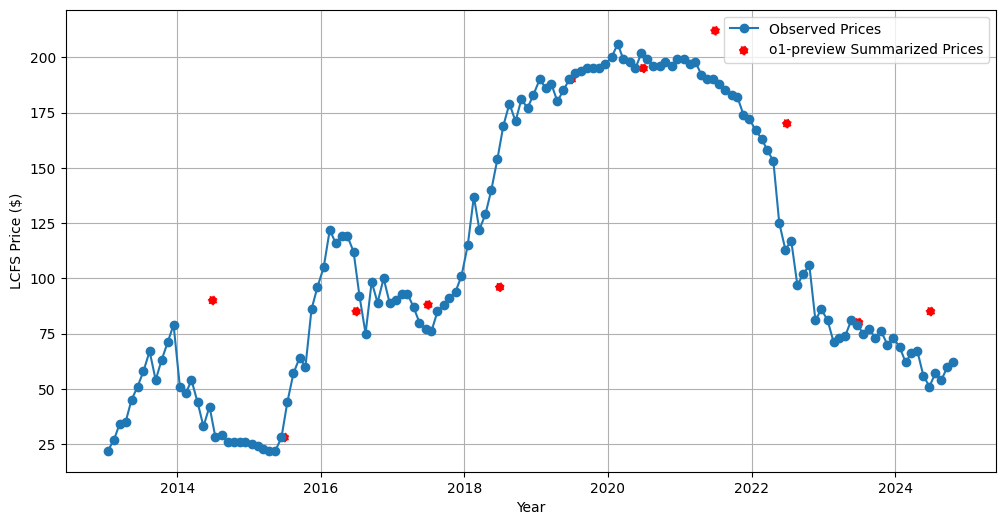

In [69]:
# Extract predicted prices and reasoning
predicted_prices = [pred['price'] for pred in predictions]
predicted_reasons = [pred['reason'] for pred in predictions]

# Get corresponding years for the predictions
dates = [pd.Timestamp(year=year, month=6, day=30) for year in range(start_year, end_year+1)]

# Ensure `start_index` matches the correct year range
start_index = lcfs[lcfs['Date'].dt.year >= 2012].index[0]

# Plot observed vs predicted prices
plt.figure(figsize=(12, 6))
plt.plot(lcfs['Date'], lcfs['Price'], label='Observed Prices', linestyle='-', marker='o')
plt.scatter(dates, predicted_prices, label='o1-preview Summarized Prices', color='r', linestyle=':')
plt.xlabel('Year')
plt.ylabel('LCFS Price ($)')
plt.legend()
plt.grid(True)
plt.savefig('/content/drive/MyDrive/0_2024_CarbonMarket_Sentiment/Long-term_prediction+reasoning/o1_summary.png', dpi=300)
plt.show()

# Save predictions to CSV
df_predictions = pd.DataFrame({
    'Date': dates,
    'Predicted_Price': predicted_prices,
    'Reason': predicted_reasons
})
df_predictions.to_csv('/content/drive/MyDrive/0_2024_CarbonMarket_Sentiment/Long-term_prediction+reasoning/o1_summary.csv', index=False)
